# Variational Autoencoders

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np

### O encoder

Nosso encoder será modelado com um espaço latente de _intermediate_dim_ dimensões.
Tanto `z_mean` quanto `z_log_sigma` possuem _intermediate_dim_ dimensões.
Iremos modelar a variância com a função $log$ por questões de estabilidade de convergência, ou seja, $log(\sigma)$ ou invés de $\sigma$.

In [2]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

Agora, iremos definir a camada de amostragem. Em nosso caso, iremos utilizar
$z = \mu + \sigma^2 * \epsilon$

In [3]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Nosso modelo de encoder é composto por $\sigma$, $\mu$, e as camadas de amostragem.

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

Agora, podemos definir a função de custo. Paraisso, iremos combinar a loss de reconstrução (podemos escolher MSE ou Cross-entropy) e a divergência KL.

In [5]:
#reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = keras.losses.mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

# Lets add the losses to our model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Pré-processamento dos dados

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
#vae.summary()

In [8]:
# Train our model 
vae.fit(x_train, x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 7s 5ms/step - loss: 63.6562 - val_loss: 51.5436
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 50.4593 - val_loss: 49.7597
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 47.4323 - val_loss: 45.3552
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 44.2004 - val_loss: 43.3924
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 42.9106 - val_loss: 42.5880
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 42.2590 - val_loss: 42.0785
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 41.7964 - val_loss: 41.6661
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 41.4347 - val_loss: 41.2930
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 41.0801 - val_loss: 40.9346
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 40.7141

In [9]:
import matplotlib.pyplot as plt

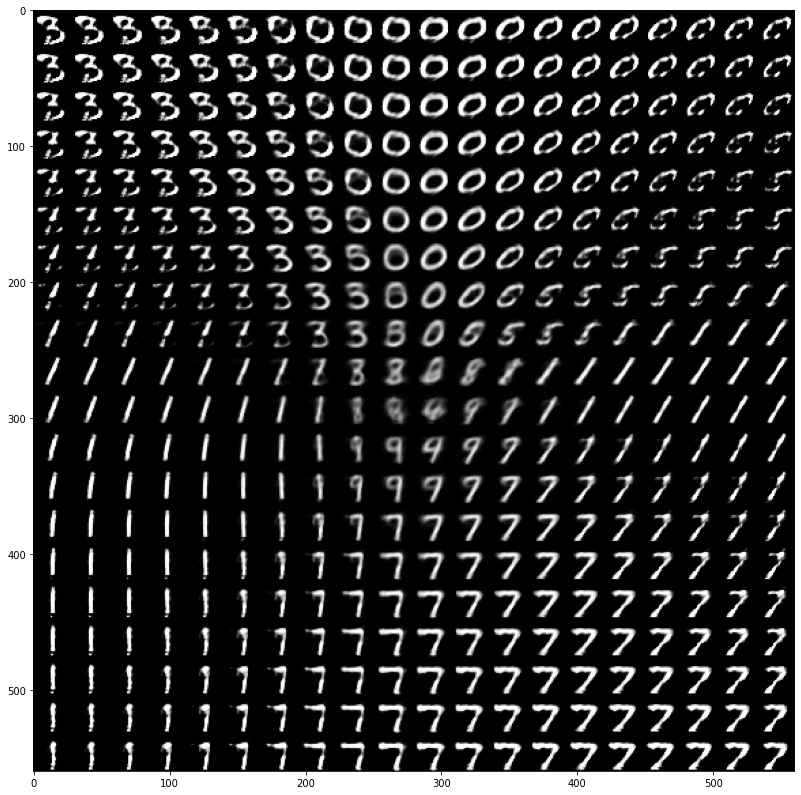

In [10]:
# Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
#figure = []

# We will sample n points within [-range, range] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)
#grid_x = np.random.normal(0, 1, n)
#grid_y = np.random.normal(0, 1, n)


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #print(z_sample)
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(14, 14))
plt.imshow(figure, cmap='gray')
plt.show()


## Exercício

1. Aplicar o mesmo VAE que nós definimos para outros bancos de dados, como o  *fashion mnist*, por exemplo, ou o [medical mnist](https://www.kaggle.com/andrewmvd/medical-mnist)
